In [49]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import seaborn as sns
from torchmetrics import Accuracy

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
img_train_data = np.load('data/dataset/np_data/img_train.npy')
img_real_data = np.load('data/dataset/np_data/img_real.npy')
label_train = np.load('data/dataset/np_data/label_train.npy')
label_real = np.load('data/dataset/np_data/label_real.npy')

In [4]:
print(img_train_data.shape)
print(img_real_data.shape)
print(label_train.shape)
print(label_real.shape)

(800, 160, 160, 1)
(10, 160, 160, 1)
(800, 1)
(10, 1)


In [5]:
label_train.dtype

dtype('uint16')

It seems that the uint16 data type is not supported in PyTorch, so let's convert the datatypes.

In [6]:
img_train_data = img_train_data.astype(np.uint8)
img_real_data = img_real_data.astype(np.uint8)
label_train = label_train.astype(np.int64)
label_real = label_real.astype(np.int64)

In [7]:
img_train_data.shape

(800, 160, 160, 1)

In [8]:
img_real_data.dtype

dtype('uint8')

Text(0.5, 1.0, 'Training Image at Index 101, Label: 1')

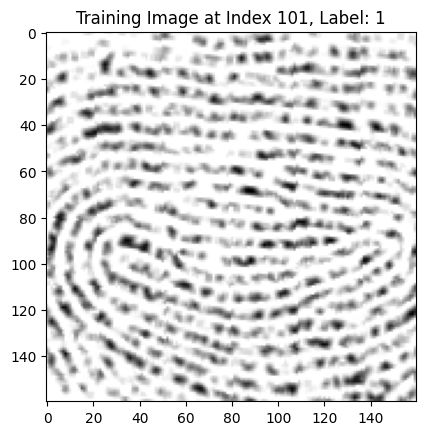

In [9]:
n = 101
plt.imshow(img_train_data[n, :, :, :],cmap='gray')
plt.title(f'Training Image at Index {n}, Label: {label_train[n][0]}')

Text(0.5, 1.0, 'Training Set Label Distributions')

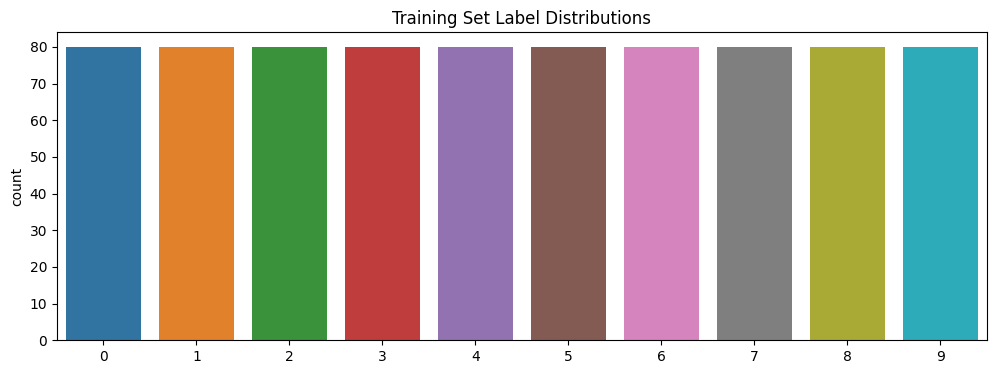

In [10]:
fig = plt.figure(figsize=(12,4))
sns.countplot(x=label_train.flatten())
plt.title('Training Set Label Distributions')

It looks like this dataset is perfectly balaned.

In [12]:
class FingerprintDataset(Dataset):
    def __init__(self, img_array, labels_array, transform=None) -> None:
        super().__init__()
        # permute to shape (800, 1, 160, 160) <- this gets down with ToTensor() transform
        self.images = img_array
        self.labels = labels_array
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image = self.images[index, :, :, :]
        if self.transform:
            image = self.transform(image)
        # .squeeze to reshape the labels from (n, 1) to (n,)
        label = self.labels[index].squeeze()
        return image, label

In [21]:
transformation = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),])

In [22]:
train_dataset = FingerprintDataset(img_array=img_train_data,
                                   labels_array=label_train, transform=transformation)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
test_dataset = FingerprintDataset(img_array=img_real_data,
                                  labels_array=label_real, transform=transformation)
test_dataloader = DataLoader(dataset=test_dataset, batch_size= 2, shuffle=False)

In [23]:
images, labels = next(iter(train_dataloader))
labels.shape

torch.Size([16])

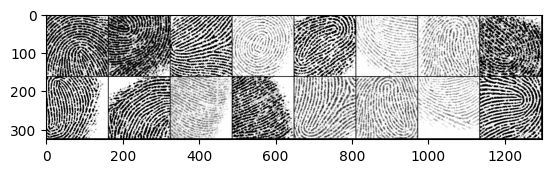

In [25]:
plt.imshow(torchvision.utils.make_grid(images).permute(1, 2, 0))

# Define the model

In [26]:
test = images[0]
test.shape

torch.Size([1, 160, 160])

In [27]:
conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
pool = nn.MaxPool2d(kernel_size=2, stride=2)
conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=2)
conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)

In [28]:
print(conv1(test).shape)
print(pool(conv1(test)).shape)
print(conv2(pool(conv1(test))).shape)
print(pool(conv2(pool(conv1(test)))).shape)
print(conv3(pool(conv2(pool(conv1(test))))).shape)
print(pool(conv3(pool(conv2(pool(conv1(test)))))).shape)

torch.Size([6, 160, 160])
torch.Size([6, 80, 80])
torch.Size([16, 80, 80])
torch.Size([16, 40, 40])
torch.Size([32, 40, 40])
torch.Size([32, 20, 20])


In [69]:
class FingerprintClassifier(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(in_features=32*20*20, out_features=200)
        self.fc2 = nn.Linear(in_features=200, out_features=80)
        self.fc3 = nn.Linear(in_features=80, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        # flatten input to pass to linear layers
        x = x.view(-1, 32*20*20)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        # Apply softmax activation
        #x = torch.nn.functional.softmax(x, dim=1)
        return x

In [70]:
model = FingerprintClassifier().to(device=device)

In [71]:
model

FingerprintClassifier(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=12800, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)

# Train the model

In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [73]:
total_steps = len(train_dataloader)
total_steps

50

In [74]:
n_epochs = 15
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print(f'Epoch: {epoch+1}/{n_epochs}, Step: {i+1}/{total_steps}, Loss:{loss.item()}')


Epoch: 1/15, Step: 10/50, Loss:2.3235554695129395
Epoch: 1/15, Step: 20/50, Loss:2.2978503704071045
Epoch: 1/15, Step: 30/50, Loss:2.2864694595336914
Epoch: 1/15, Step: 40/50, Loss:2.318697452545166
Epoch: 1/15, Step: 50/50, Loss:2.287187337875366
Epoch: 2/15, Step: 10/50, Loss:2.3437001705169678
Epoch: 2/15, Step: 20/50, Loss:2.314970016479492
Epoch: 2/15, Step: 30/50, Loss:2.3489041328430176
Epoch: 2/15, Step: 40/50, Loss:2.2873408794403076
Epoch: 2/15, Step: 50/50, Loss:2.2860400676727295
Epoch: 3/15, Step: 10/50, Loss:2.3340442180633545
Epoch: 3/15, Step: 20/50, Loss:2.30088472366333
Epoch: 3/15, Step: 30/50, Loss:2.3707826137542725
Epoch: 3/15, Step: 40/50, Loss:2.271129608154297
Epoch: 3/15, Step: 50/50, Loss:2.0666842460632324
Epoch: 4/15, Step: 10/50, Loss:1.9019964933395386
Epoch: 4/15, Step: 20/50, Loss:2.237948417663574
Epoch: 4/15, Step: 30/50, Loss:1.907956600189209
Epoch: 4/15, Step: 40/50, Loss:2.0117886066436768
Epoch: 4/15, Step: 50/50, Loss:2.100609064102173
Epoch: 5/

# Evaluation

In [75]:
model.eval()

FingerprintClassifier(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=12800, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)

In [76]:
accuracy = Accuracy(task='multiclass', num_classes=10)

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)

        _, preds = torch.max(outputs, dim=1)
        accuracy.update(preds, labels)

In [77]:
acc = accuracy.compute()
print(f'Accuracy on test set: {100*acc:.2f}%')

Accuracy on test set: 70.00%
